# E2E Pipeline RGB Basic
Trying something different
- Input satellite images
- Do feature extraction without fine tuning
- Linear regression on top of features extracted

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt

import os
import PIL

pd.options.mode.chained_assignment = None

# Enable GPU    

In [2]:
print('TensorFlow version: {}'.format(tf.__version__))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found - On for CPU time!')
else:
    print('Found GPU at {}'.format(device_name))

TensorFlow version: 2.13.0
GPU device not found - On for CPU time!


# Understand images

In [3]:
import glob
path = '../outputs/tiled-satellite-images-rgb'

training_img = glob.glob(f'{path}/*.png')
print('There are {} images in the training directory'.format(len(training_img)))

img_sz = {'width': list(),
         'height': list()} # store image attributes for further analysis
width, height = 1000, 1000

for im in training_img:
    print(im)
    img = PIL.Image.open(im)
    w, h = img.size
    if w < width:
        width = w
    if h < height:
        height = h

IMG_WIDTH = width
IMG_HEIGHT = height
IMG_CHANNELS = 3

print('Min training image width: {} px'.format(IMG_WIDTH))
print('Min training image height: {} px'.format(IMG_HEIGHT))

There are 5850 images in the training directory
../outputs/tiled-satellite-images-rgb\0001.png
../outputs/tiled-satellite-images-rgb\0002.png
../outputs/tiled-satellite-images-rgb\0003.png
../outputs/tiled-satellite-images-rgb\0004.png
../outputs/tiled-satellite-images-rgb\0005.png
../outputs/tiled-satellite-images-rgb\0006.png
../outputs/tiled-satellite-images-rgb\0007.png
../outputs/tiled-satellite-images-rgb\0008.png
../outputs/tiled-satellite-images-rgb\0009.png
../outputs/tiled-satellite-images-rgb\0010.png
../outputs/tiled-satellite-images-rgb\0011.png
../outputs/tiled-satellite-images-rgb\0012.png
../outputs/tiled-satellite-images-rgb\0013.png
../outputs/tiled-satellite-images-rgb\0014.png
../outputs/tiled-satellite-images-rgb\0015.png
../outputs/tiled-satellite-images-rgb\0016.png
../outputs/tiled-satellite-images-rgb\0017.png
../outputs/tiled-satellite-images-rgb\0018.png
../outputs/tiled-satellite-images-rgb\0019.png
../outputs/tiled-satellite-images-rgb\0020.png
../outputs/t

Reading and displaying images

### Build the training dataset

(2470, 12)
(2470,)


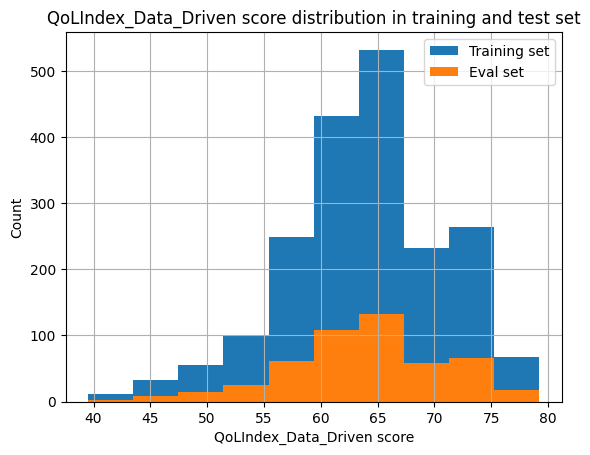

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

data_path = '../outputs/clustered-data-gauteng.csv'
data = pd.read_csv(data_path, dtype={"image":"string"})

# Use stratified sampling
sssplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
print(data.shape)
print(data['QoLIndex_Data_Driven'].shape)
for train_index,test_index in sssplit.split(data, data['QoLIndex_Data_Driven']):
    training_set = data.iloc[train_index]
    eval_set = data.iloc[test_index]
    
# Visually check the distribution of service_index score in training and test sets
training_set['QoLIndex_Data_Driven'].hist(label='Training set')
eval_set['QoLIndex_Data_Driven'].hist(label='Eval set')
plt.title('QoLIndex_Data_Driven score distribution in training and test set')
plt.xlabel('QoLIndex_Data_Driven score')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

# Export training and test sets as .csv files
training_set['filename'] = training_set['image'].apply(lambda x: f'../outputs/tiled-satellite-images-rgb/{x}.png')
training_set[['filename', 'QoLIndex_Data_Driven']].to_csv('../outputs/hack/working/training_set.csv', header=False, index=False)
eval_set['filename'] = eval_set['image'].apply(lambda x: f'../outputs/tiled-satellite-images-rgb/{x}.png')
eval_set[['filename', 'QoLIndex_Data_Driven']].to_csv('../outputs/hack/working/eval_set.csv', header=False, index=False)

### Some functions

In [28]:
def read_and_decode(filename, reshape_dims):
    # Read an image file to a tensor as a sequence of bytes
    image = tf.io.read_file(filename)
    # Convert the tensor to a 3D uint8 tensor
    image = tf.image.decode_png(image, channels=IMG_CHANNELS)
    # Convert 3D uint8 tensor with values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to the desired size
    return tf.image.resize(image, reshape_dims)

def show_image(filename):
    image = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    plt.imshow(image.numpy())
    plt.axis('off')

def decode_csv(csv_row):
    record_defaults = ['filename', 'service_index']
    filename, service_index = tf.io.decode_csv(csv_row, record_defaults)
    service_index = tf.convert_to_tensor(float(service_index), dtype=tf.float32)
    image = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    return image, service_index

## Import training & eval datasets

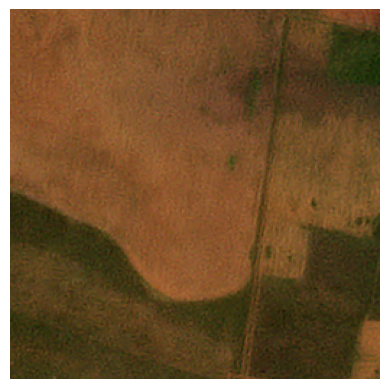

In [29]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

path = '../outputs/tiled-satellite-images-rgb'
training_img = glob.glob(f'{path}/*.png')
rand_idx = np.random.randint(0, len(training_img)-1)
rand_img = training_img[rand_idx]

show_image(rand_img)

In [30]:
BATCH_SIZE = 256

train_dataset = tf.data.TextLineDataset(
    '../outputs/hack/working/training_set.csv'
).map(decode_csv).batch(BATCH_SIZE)

eval_dataset = tf.data.TextLineDataset(
    '../outputs/hack/working/eval_set.csv'
).map(decode_csv).batch(BATCH_SIZE)

## Build CNN

In [31]:
# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None)
])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 64)      0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1032256)           0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1032257   
                                                                 
Total params: 1034049 (3.94 MB)
Trainable params: 1034049 (3.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [35]:
%%time

history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10, batch_size=BATCH_SIZE)

Epoch 1/10
8/8 [==============================] - 25s 3s/step - loss: 1388.1108 - root_mean_squared_error: 37.2574 - val_loss: 727.0152 - val_root_mean_squared_error: 26.9632
Epoch 2/10
8/8 [==============================] - 24s 3s/step - loss: 633.7742 - root_mean_squared_error: 25.1749 - val_loss: 448.3067 - val_root_mean_squared_error: 21.1733
Epoch 3/10
8/8 [==============================] - 24s 3s/step - loss: 314.7827 - root_mean_squared_error: 17.7421 - val_loss: 280.2353 - val_root_mean_squared_error: 16.7402
Epoch 4/10
8/8 [==============================] - 26s 3s/step - loss: 214.3414 - root_mean_squared_error: 14.6404 - val_loss: 176.8454 - val_root_mean_squared_error: 13.2983
Epoch 5/10
8/8 [==============================] - 26s 3s/step - loss: 142.3971 - root_mean_squared_error: 11.9330 - val_loss: 104.5065 - val_root_mean_squared_error: 10.2228
Epoch 6/10
8/8 [==============================] - 28s 3s/step - loss: 97.8137 - root_mean_squared_error: 9.8901 - val_loss: 88.32

In [36]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel('Epochs')
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_'+metric]);
        ax[idx].legend(['train_'+metric, 'val_'+metric])

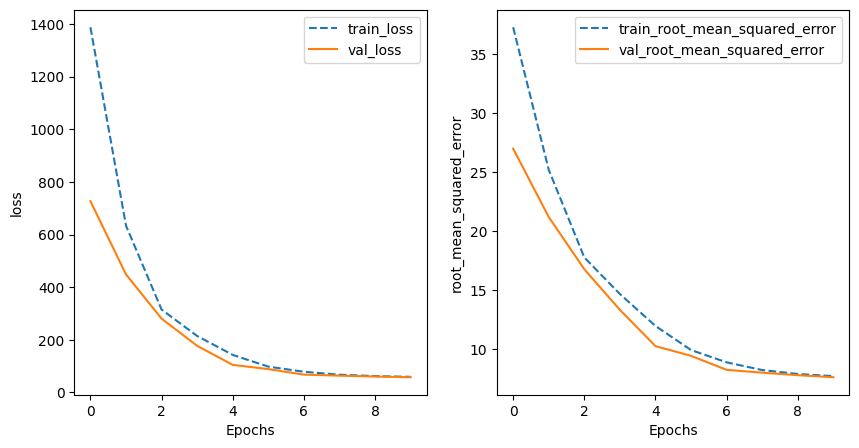

In [37]:
training_plot(['loss', 'root_mean_squared_error'], history)

## Notes & Takeaways

- I was following [this tutorial](https://www.kaggle.com/code/emilyrosesteyn/convolutional-neural-network-for-image-regression/edit) for image regression
- The shuffle split algorithm requires more image data than what I had clustered. 
- I want to build my pipeline:
    - Data downloading (satellite image data, GCRO data, municipal boundaries data, DHS data for SA)
    - Module for clustering data
    - Module for downloading satellite images for clusters
    - Class for feature extraction/encoding - see geocolab